# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Примечания:**

1. Не ограничиваться градиентным бустингом.
2. Для оценки качества моделей применять метрику RMSE. RMSE должно быть меньше 2500.
3. Освоить библиотеку LightGBM и её средствами построить модели градиентного бустинга.
4. Ввести время выполнения ячейки кода.
5. В модели градиентного бустинга допускается изменять только два-три параметра.

**План исследования:**

1. Обзор данных.
2. Подготовка данных.
3. Обучение моделей.
4. Анализ моделей.
5. Вывод.

## Обзор данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
display(df.head())
print()
display(df.info())
print()
display(df.describe())
print()
print('Количество пропусков:')
display(df.isna().sum())
print()
print('Количество дубликатов:', df.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Количество пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Количество дубликатов: 4


**Вывод п.1.**
Целевой признак - Price. Признаки DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen не влияют на цену, можно удалить. От явных дубликатов также избавимся. В признаках, влияющих на цену, есть пропуски. В колонке RegistrationYear указан минимальный год 1000, надо проверить и другие аномалии. Названиях признаков надо привести к змеиному стилю. Значения в столбцах Gearbox и NotRepaired можно заменить на 1 или 0. В целевом признаке Price и признаке Power есть нули, чуть позже посмотрим внимательнее.

## Подготовка данных

Приводим названия колонок к змеиному стилю:

In [4]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Удалим признаки, не влияющие на целевой признак:

In [5]:
df.drop(columns=['date_crawled', 'date_created', 'number_of_pictures',
                    'postal_code', 'last_seen', 'registration_month'],
           axis=1,
           inplace=True)

Удалим дубликаты:

In [6]:
df.drop_duplicates(inplace=True)  

**2.1 Целевой признак price:**

Оценим количество нулей в колонке и примем решение:

In [7]:
df.price.value_counts()

0        8904
500      4650
1500     4533
1000     3875
1200     3799
         ... 
1654        1
5748        1
7285        1
11379       1
8188        1
Name: price, Length: 3731, dtype: int64

In [8]:
df = df.query('price > 0')

Построим гистограмму и диаграмму размаха для целевого признака: 

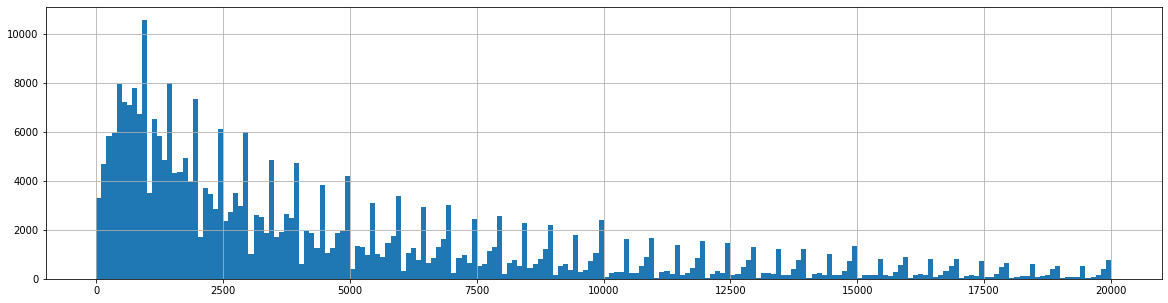

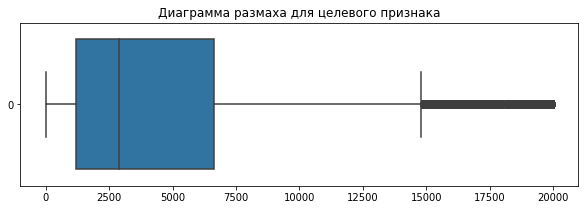

In [9]:
df.price.hist(bins=200, figsize=(20,5))

plt.figure(figsize=(10,3))
sns.boxplot(data=df.price, orient='h')
plt.title('Диаграмма размаха для целевого признака')
plt.show()

Видим данные у нуля и хвост возле 15000. Надо посмотреть на квантили:

In [10]:
df.price.quantile([.05, 0.95])

0.05      350.0
0.95    14900.0
Name: price, dtype: float64

Оценим долю строк, где цена меньше 350 и больше 14900 и примем решение:

In [11]:
1 - df.query('350 < price').shape[0] / df.shape[0]

0.0549654655904136

In [12]:
df = df.query('350 < price')

**2.2 Признак registration_year:**

Оценим значения в registration_year:

In [13]:
df.registration_year.value_counts()

2005    18530
2000    17605
2006    16970
1999    16796
2004    16541
        ...  
1946        1
1949        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 133, dtype: int64

Поступим следующим образом - верхнюю границу установим как самый поздний год выгрузки данных, нижнюю границу установим на уровне 1975 года (ранее выпущенные авто вряд ли поставлены на учет и выставлены на продажу):

In [14]:
df_ = pd.read_csv('/datasets/autos.csv')
df_.DateCrawled.max()

'2016-04-07 14:36:58'

In [15]:
df = df.query('1975 <= registration_year <= 2016')

**2.3 Признак power:**

Оценим значения в колонке power:

In [16]:
df.power.value_counts()

0        23890
75       16407
150      11686
140      10373
60       10151
         ...  
1700         1
1079         1
421          1
10912        1
1199         1
Name: power, Length: 658, dtype: int64

In [17]:
df.power.describe()

count    269488.000000
mean        116.143992
std         194.850286
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: power, dtype: float64

Самое мощное на 2022 год легковое авто Dagger GT компании TranStar Racing LLC имеет 2028 лс, а самое слабое из представленных брендов Citroen 2CV - имеет 9лс, удалим из датасета данные выше и ниже этих границ:

In [18]:
df = df.query('9 <= power <= 2028')

**2.4 Признак kilometer:**

Оценили значения в столбце kilometer, аномалий не выявлено:

In [19]:
df.kilometer.value_counts()

150000    158044
125000     27664
100000     11178
90000       9096
80000       8008
70000       7035
60000       5979
50000       5032
40000       3981
30000       3375
20000       2852
5000        2292
10000        804
Name: kilometer, dtype: int64

**2.5 Признак brand:**

Оценили значения в столбце brand, неявных дубликатов нет:

In [20]:
df.brand.value_counts()

volkswagen        50442
bmw               27136
opel              25077
mercedes_benz     24045
audi              21873
ford              16596
renault           11161
peugeot            7946
fiat               6163
seat               4933
skoda              4403
mazda              4082
smart              4077
citroen            3747
toyota             3662
nissan             3427
hyundai            2788
mini               2629
volvo              2420
mitsubishi         2159
honda              2140
kia                1870
alfa_romeo         1725
suzuki             1716
chevrolet          1331
sonstige_autos     1323
chrysler           1044
dacia               732
subaru              568
porsche             557
jeep                529
daihatsu            500
land_rover          421
saab                417
jaguar              408
daewoo              333
lancia              316
rover               295
trabant             208
lada                141
Name: brand, dtype: int64

**2.6. Признак gearbox:**

Заменим пропуски на 'manual', а затем значение manual на 1 и auto - на 0, поменяем тип данных:

In [21]:
df.fillna({'gearbox':'manual'}, inplace=True)

df.loc[(df.gearbox == 'manual'), 'gearbox'] = 1   
df.loc[(df.gearbox == 'auto'), 'gearbox'] = 0

df.gearbox = df.gearbox.astype('int')

**2.7 Признак repaired:**

Заменим пропуски на 'yes' - любая подержанная машина была в ремонте, затем значение yes на 1, no - на 0, поменяем тип данных:

In [22]:
df.fillna({'repaired':'yes'}, inplace=True)

df.loc[(df.repaired == 'yes'), 'repaired'] = 1
df.loc[(df.repaired == 'no'), 'repaired'] = 0

df.repaired = df.repaired.astype('int')

**2.8 Признак model:**

Заменим пропуски на 'unknown':

In [23]:
df.fillna({'model':'unknown'}, inplace=True)
df.model.value_counts()

golf                  18978
other                 17740
3er                   14341
unknown                9321
polo                   7572
                      ...  
kalina                    4
serie_2                   3
rangerover                2
serie_3                   2
range_rover_evoque        1
Name: model, Length: 250, dtype: int64

**2.9 Признак vehicle_type:**

Меняем пропуски на unknown:

In [24]:
df.fillna({'vehicle_type':'unknown'}, inplace=True)
df.vehicle_type.value_counts()

sedan          68664
small          53963
wagon          49770
bus            23200
convertible    16527
coupe          12625
suv             9721
unknown         8703
other           2167
Name: vehicle_type, dtype: int64

**2.10 Признак fuel_type:**

Аналогичная обработка:

In [25]:
df.fillna({'fuel_type':'unknown'}, inplace=True)
df.fuel_type.value_counts()

petrol      152103
gasoline     75221
unknown      13043
lpg           4228
cng            431
hybrid         190
other           64
electric        60
Name: fuel_type, dtype: int64

In [26]:
df.fuel_type = df.fuel_type.replace('gasoline', 'petrol')

<AxesSubplot:xlabel='fuel_type', ylabel='count'>

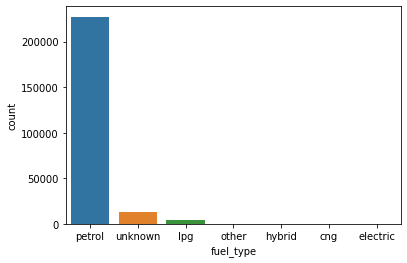

In [27]:
sns.countplot(df.fuel_type)

Смотрим на результат обработки данных:

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245340 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              245340 non-null  int64 
 1   vehicle_type       245340 non-null  object
 2   registration_year  245340 non-null  int64 
 3   gearbox            245340 non-null  int64 
 4   power              245340 non-null  int64 
 5   model              245340 non-null  object
 6   kilometer          245340 non-null  int64 
 7   fuel_type          245340 non-null  object
 8   brand              245340 non-null  object
 9   repaired           245340 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 28.7+ MB


Вывод п.2. Мы провели обработку данных. Удалили признаки, не влияющие на целевой признак, привели названия к нужному стилю, избавились от дубликатов. Заполнили пропуски в gearbox значением 'manual', и далее на 1/0,  пропуски в repaired значением 'yes', и далее на 1/0, в model, vehicletype, fuel_type значением 'unknown'. В результате обработки данных датафрейм сократился, но данные стали качественнее, исчезли шумы и аномалии и их (данных) количества вполне достаточно для обучения моделей.

## Обучение моделей

Выделим целевой признак:

In [29]:
target = df['price'] 

Оставим оригинальные признаки и разделим выборки:

In [30]:
features_master = df.drop('price', axis=1)
                                    
#features_train_master, features_test_master, target_train, target_test = \
#train_test_split(features_master, target, test_size=0.25, random_state=12345)

Закодируем признаки через OHE:

In [31]:
features_ohe = pd.get_dummies(features_master, drop_first=True)

features_train_ohe, features_test_ohe, target_train_ohe, \
target_test_ohe = train_test_split(features_ohe, target, test_size=.25, random_state=12345)

Закодируем признаки через OE (прямое кодирование):

In [33]:
features_oe = features_master.copy()
   

features_train_oe, features_test_oe, target_train_oe, \
target_test_oe = train_test_split(features_oe, target, test_size=.25, random_state=12345)

columns_cat = ['vehicle_type','fuel_type','brand','model']

oe_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

features_train_oe[columns_cat] = oe_encoder.fit_transform(features_train_oe[columns_cat])
features_test_oe[columns_cat] = oe_encoder.transform(features_test_oe[columns_cat])


**3.1 Модель LinearRegression:**

На выборках c OHE:

In [34]:
%%time

model_lr = LinearRegression()

cvs_rmse_lr = (cross_val_score(model_lr,
                               features_train_ohe,
                               target_train_ohe,
                               cv=5,
                               scoring='neg_mean_squared_error')).mean() * -1 ** .5
cvs_rmse_lr

CPU times: user 40.2 s, sys: 38.1 s, total: 1min 18s
Wall time: 1min 18s


6986101.182974639

На выборках c OE:

In [36]:
%%time

model_lr = LinearRegression()

cvs_rmse_lr = (cross_val_score(model_lr,
                               features_train_oe,
                               target_train_oe,
                               cv=5,
                               scoring='neg_mean_squared_error')).mean() * -1 ** .5
cvs_rmse_lr

CPU times: user 409 ms, sys: 487 ms, total: 896 ms
Wall time: 907 ms


10303154.429948185

**3.2 Модель CatBoostRegressor:**

На выборках c OHE:

In [ ]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_ohe, target_train_ohe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_ohe = (max(mts) * -1) ** .5
gscv_rsme_cbr_ohe

In [39]:
%%time

#model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False)
model_cbr.fit(features_train_ohe, target_train_ohe)

461:	learn: 1640.1715716	total: 9.99s	remaining: 11.6s
462:	learn: 1639.9063609	total: 10s	remaining: 11.6s
463:	learn: 1639.6629451	total: 10s	remaining: 11.6s
464:	learn: 1639.4307060	total: 10.1s	remaining: 11.6s
465:	learn: 1639.2486274	total: 10.1s	remaining: 11.5s
466:	learn: 1639.0383908	total: 10.1s	remaining: 11.5s
467:	learn: 1638.9002476	total: 10.1s	remaining: 11.5s
468:	learn: 1638.6826586	total: 10.1s	remaining: 11.5s
469:	learn: 1638.5502379	total: 10.2s	remaining: 11.4s
470:	learn: 1638.3768482	total: 10.2s	remaining: 11.4s
471:	learn: 1638.3178764	total: 10.2s	remaining: 11.4s
472:	learn: 1638.0518960	total: 10.2s	remaining: 11.4s
473:	learn: 1637.8247577	total: 10.2s	remaining: 11.4s
474:	learn: 1637.6933977	total: 10.3s	remaining: 11.3s
475:	learn: 1637.5160006	total: 10.3s	remaining: 11.3s
476:	learn: 1637.3351813	total: 10.3s	remaining: 11.3s
477:	learn: 1637.1156923	total: 10.3s	remaining: 11.3s
478:	learn: 1636.8284449	total: 10.3s	remaining: 11.2s
479:	learn: 16

In [40]:
%%time

target_predict = model_cbr.predict(features_train_ohe)

CPU times: user 386 ms, sys: 350 µs, total: 387 ms
Wall time: 385 ms


На выборках c OE:

In [42]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_oe, target_train_oe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_oe = (max(mts) * -1) ** .5
gscv_rsme_cbr_oe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 5min, sys: 2.1 s, total: 5min 2s
Wall time: 5min 20s


1617.645024723503

In [43]:
%%time

#model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) 
model_cbr.fit(features_train_oe, target_train_oe)

Learning rate set to 0.09333
0:	learn: 4367.2389618	total: 44.2ms	remaining: 44.2s
1:	learn: 4117.0743703	total: 81.3ms	remaining: 40.6s
2:	learn: 3893.9738218	total: 115ms	remaining: 38.3s
3:	learn: 3691.4032976	total: 150ms	remaining: 37.3s
4:	learn: 3512.9554013	total: 174ms	remaining: 34.5s
5:	learn: 3353.3942169	total: 196ms	remaining: 32.5s
6:	learn: 3210.7303418	total: 221ms	remaining: 31.3s
7:	learn: 3084.4348676	total: 245ms	remaining: 30.3s
8:	learn: 2972.6429916	total: 269ms	remaining: 29.6s
9:	learn: 2875.4033946	total: 291ms	remaining: 28.8s
10:	learn: 2790.3021324	total: 318ms	remaining: 28.5s
11:	learn: 2710.3227326	total: 346ms	remaining: 28.5s
12:	learn: 2644.2444945	total: 373ms	remaining: 28.3s
13:	learn: 2586.2279279	total: 399ms	remaining: 28.1s
14:	learn: 2533.8210947	total: 424ms	remaining: 27.9s
15:	learn: 2485.3632587	total: 449ms	remaining: 27.6s
16:	learn: 2437.9341822	total: 479ms	remaining: 27.7s
17:	learn: 2401.5548548	total: 516ms	remaining: 28.2s
18:	lea

In [44]:
%%time

target_predict = model_cbr.predict(features_train_oe)

CPU times: user 191 ms, sys: 216 µs, total: 192 ms
Wall time: 190 ms


**3.3 Модель LightGBMRegressor:**

На выборках c OHE:

In [46]:
model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_ohe, target_train_ohe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

gscv_rsme_lgbmr_ohe = (max(mts) * -1) ** .5
gscv_rsme_lgbmr_ohe

{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}



1604.32827012054

In [47]:
%%time

model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 5.5 s, sys: 155 ms, total: 5.65 s
Wall time: 5.6 s


LGBMRegressor()

In [48]:
%%time

target_predict = model_lgbmr.predict(features_train_ohe)

CPU times: user 1.95 s, sys: 150 ms, total: 2.1 s
Wall time: 2.11 s


На выборках c OE:

In [50]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_oe, target_train_oe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

gscv_rsme_lgbmr_oe = (max(mts) * -1) ** .5
gscv_rsme_lgbmr_oe

{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}

CPU times: user 53min 54s, sys: 9.17 s, total: 54min 3s
Wall time: 54min 14s


1613.361142443353

In [51]:
%%time

model_lgbmr.fit(features_train_oe, target_train_oe)

CPU times: user 4.07 s, sys: 20 ms, total: 4.09 s
Wall time: 4.1 s


LGBMRegressor()

In [52]:
%%time

target_predict = model_lgbmr.predict(features_train_oe)

CPU times: user 1.46 s, sys: 2.31 ms, total: 1.46 s
Wall time: 1.52 s


Вывод п.3. Мы рассмотрели три модели - LinearRegression. Модель LinearRegression с 7-8 значной метрикой RMSE, полученной кроссвалидацией, рассматривать дальше не будем. Обучение моделей CatBoostRegressor и LGBMRegressor проводилось на выборках с кодировкой OE и кодировкой OHE. Анализ и финальное тестирование лучшей модели будет следующим шагом. 

## Анализ моделей

Подставим лучшие гиперпараметры в модель и проверим ее на тестовой выборке:

In [55]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False)
model_cbr.fit(features_train_ohe, target_train_ohe)

CPU times: user 22.1 s, sys: 137 ms, total: 22.3 s
Wall time: 23.2 s


In [56]:
%%time

target_predict_ohe = model_cbr.predict(features_test_ohe)

CPU times: user 102 ms, sys: 3.78 ms, total: 106 ms
Wall time: 106 ms


In [57]:
final_rsme_cbr_ohe = mean_squared_error(target_test_ohe, target_predict_ohe) ** .5
final_rsme_cbr_ohe

1569.6730222511164

Финальные данные добавляем в сравнительную таблицу:

In [58]:
kpi_data.loc['Финальные данные лучшей модели'] = [final_rsme_cbr_ohe, 24.80, 0.14, \
                                        final_rsme_cbr_ohe * .34 + 24.80 * .33 + 0.14 * .33]
kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
LGBMRegressor_OHE,0.000000,0.0,0.00,0.000000
LGBMRegressor_OE,0.000000,0.0,0.00,0.000000
Финальные данные лучшей модели,1569.673022,24.8,0.14,541.919028
CatBoostRegressor_OHE,1596.670000,32.6,0.43,553.767700
CatBoostRegressor_OE,1617.650000,32.7,0.21,560.861300


**Общий вывод.** В ходе выполнения проекта были загружены данные и проведена их предобработка. Выполнено обучение моделей с подбором гиперпараметров. Выбрана лучшая модель по результатам метрики RMSE, времени обучения и времени предсказания. Для общей оценки по трем параметрам был собран относительный рейтинг. Качество лучшей модели было проверено на тестовой выборке. Финальная модель на тестовой выборке показала результат RMSE = 1569.67, временем обучения 24.80 и временем предсказания 0.14. 